In [59]:
import pandas as pd
import numpy as np

df_clean_1 = pd.read_csv('log_1.csv')
df_dirty_1 = pd.read_csv('log_2.csv')

#its a list containing the max and min allowed value
#assumption: max and min provided are the max mins of the reporting sensor/component
validation_list = [{'index': 1, 'min': -1, 'max': 8800}, {'index': 2, 'min': 0, 'max': 8192}, {'index': 3, 'min': 0, 'max': 100}, 
                           {'index': 4, 'min': -400}, {'index': 5, 'min': -40 }, {'index': 6, 'min': -40}, {'index': 7, 'min': 70, 'max': 110}]

col_names = ['Time (s)', 'Motor Speed (RPM)', 'Engine Speed (RPM)', 'Throttle (%)',
       'Intake Temperature (C)', 'Engine Coolant Temperature 1 (C)',
       'Engine Coolant Temperature 2 (C)', 'Barometric Pressure (kpa)',
       'Fuel Trim', 'Fuel Consumption (g/min)', 'Fuel Consumed (g)',
       'Expected BSFC (g/kW.hr)', 'Actual BSFC (g/kW.hr)',
       'Expected Max Power (W)', 'Bus Voltage (V)', 'GCU Current (A)',
       'Battery Current (A)', 'Power Generated (W)', 'GCU Phase Current (A)',
       'Inverter Temperature (C)', 'Target Fuel Pressure (bar)',
       'Fuel Pressure (bar)', 'Fuel Pump Speed (RPM)',
       'Cooling Pump Speed (RPM)', ' Fans On (qty)', ' PWM Uptime (s)']


#create a report obj to track status


def clean_df(df_raw, fault_cutoff_percentage = 0.2, reset_index_time = True, should_validate = False, corr_obj = {'should_apply_corr': False, 'corr': 0.75, 'drop_uncorr' : False }):
    cleaning_report = {}
    try:
        #check if all columns are accountable for
        #check for column length
        #currently assuming cols are locked into place
        if len(df_raw.columns) != 26:
            cleaning_report['result'] = False
            cleaning_report['description'] = 'Failed to clean, shape of data not what is expected'

            raise Exception('df has incorrect numnber of cols')
        
        #set up error percentage tracker
        total_count = len(df_raw)
        
        cleaning_report['total_count'] = total_count
        cleaning_report['total_isna_missing'] = df_raw.isna().sum().sum()

        permissible_error_count = int(total_count * fault_cutoff_percentage)
        error_count = 0

        #convert all values to float and convert those that cannot be converted to Nan
        df_raw = df_raw.apply(pd.to_numeric, errors='coerce')


        #get the number of rows containing na values
        total_na_count = df_raw.isna().sum().sum()
        cleaning_report['inparsible_count'] = total_na_count - cleaning_report['total_isna_missing']

        if total_na_count != 0:
            rows_with_na = df_raw.isna().any(axis=1)
            list_of_na_rows = df_raw.index[rows_with_na].tolist()

            df_raw.drop(list_of_na_rows, inplace=True)
            error_count += len(list_of_na_rows)

        #check for columns in the validation list if the given values
        cleaning_report['vals_out_of_range_count'] = 0

        cols = df_raw.columns
        for validation_checks in validation_list:
            #fetch validation checks
            check_index = validation_checks['index']
            min_permissible = validation_checks.get('min', None)
            max_permissible = validation_checks.get('max', None)
            
            vals = df_raw[cols[check_index]]

            indices_outside_permissible_values = []
            if max_permissible is not None and min_permissible is not None:
                indices_outside_permissible_values = vals[(vals < min_permissible) | (vals > max_permissible)].index.tolist()
            elif max_permissible is not None:
                indices_outside_permissible_values = vals[vals > max_permissible].index.tolist()
            else:
                indices_outside_permissible_values = vals[vals < min_permissible].index.tolist()

            df_raw.drop(indices_outside_permissible_values, inplace=True)
            error_count += len(indices_outside_permissible_values)

            cleaning_report['vals_out_of_range_count'] += len(indices_outside_permissible_values)
        
        #check if error_count exceeds
        if error_count >= permissible_error_count:
            cleaning_report['result'] = False
            cleaning_report['description'] = 'Failed to clean, overall error count greater than permissible value'

            raise Exception('df has too many errors')
        

        #make column names uniform
        df_raw.columns = col_names

        #drop time column and make it the index
        #WARNING: do not set to true if planning to clean and combine multiple dataframes
        if(reset_index_time):
            df_raw = df_raw.set_index(col_names[0], drop = True)

        cleaning_report['result'] = True
        cleaning_report['description'] = 'cleaning successful'

        return (df_raw, cleaning_report)
    except Exception as err:
        print("clean_df:{err}".format(err = err))
        return (None, cleaning_report)


In [79]:
#validate rows and add meta data
#WARNING: validate_df assumes data to be cleaned
def validate_motor_speed(df):
    try:
        #validate motor speed
        motor_speed_col_name = col_names[1]
        engine_speed_col_name = col_names[2]

        throttle_percentage_col_name = col_names[3]
        power_generated_col_name = col_names[17]

        motor_speed_vals = df[motor_speed_col_name]
        engine_speed_vals = df[engine_speed_col_name]

        throttle_percentage_vals = df[throttle_percentage_col_name]
        power_generated_vals = df[power_generated_col_name]

        motor_speed_change = motor_speed_vals.pct_change()
        

        motor_engine_ratio = motor_speed_vals/engine_speed_vals
        motor_throttle_ratio = motor_speed_vals/throttle_percentage_vals

        motor_power_ratio = motor_speed_vals/power_generated_vals
        df_motor_speed_analysis = pd.DataFrame({
            'motor_speed': motor_speed_vals,
            'motor_speed_change': motor_speed_change.replace([np.inf, -np.inf], np.nan),
            'motor_engine_ratio': motor_engine_ratio,
            'motor_throttle_ratio': motor_throttle_ratio,
            'motor_power_ratio': motor_power_ratio

        }, index=df.index)


        df_motor_speed_analysis.index = df.index
        return df_motor_speed_analysis
    except Exception as err:
        print("validate_df:{err}".format(err = err))
        raise err

def validate_engine_speed(df):
    #validate engine speed
    try:
        motor_speed_col_name = col_names[1]
        engine_speed_col_name = col_names[2]

        #TBD:
        #1. Look for a portion where the engine speed is fixed for a period of 10s
        #2. Compare values with the motor speed and PMP uptime
        #       if PMP UPtime = 0 and rate of motor speed falling: engine is off
        #       if PMP Uptime = 1 and engine speed at 8192: engine speed maxed
        #       if above and Motor speed continuing upward trend: engine maxed out warning  
    except Exception as err:
        print("validate_df:{err}".format(err = err))
        raise err

def validate_intake_temperature(df):
    #validate intake temperature:
    #return a set of temperatures where value is greater than 45
    try:
        intake_temperature_col_name = col_names[4]
        return df.index[df[intake_temperature_col_name] > 45].tolist()
    except Exception as err:
        print("validate_df:{err}".format(err = err))
        raise err

def validate_engine_coolant_temperature(df):
    #validate engine coolant temperature
    #return a set of indices where temperature greater than 91
    try:
        engine_coolant_col_name_1 = col_names[5]
        engine_coolant_col_name_2 = col_names[6]

        warning_indices =  df.index[((df[engine_coolant_col_name_1] > 91) & (df[engine_coolant_col_name_1] < 98)) | ((df[engine_coolant_col_name_2] > 91) & (df[engine_coolant_col_name_2] < 98))].tolist()
        shutoff_indices = df.index[(df[engine_coolant_col_name_1] > 98) | (df[engine_coolant_col_name_2] > 98)].tolist()

        return (warning_indices, shutoff_indices)
    except Exception as err:
        print("validate_df:{err}".format(err = err))
        raise err
    
def validate_barometric_pressure(df):
    try:
        return df[(df[col_names[7]] < 70) & (df[col_names[7]] > 110)].tolist()
    except Exception as err:
        print("validate_df:{err}".format(err = err))
        raise err

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(df):
    for col in df.columns:
        print('plotting', col)
        plt.plot(df.index, df[col])
        plt.show()




In [12]:
len(df_clean_1)

2897

In [74]:
df_clean, clean_report = clean_df(df_clean_1)
df_dirty, dirty_report = clean_df(df_dirty_1)

plotting motor_speed


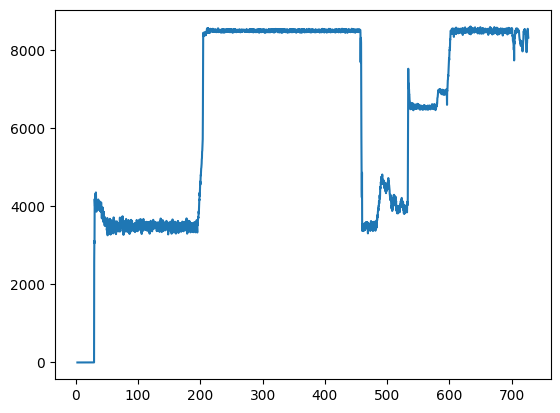

plotting motor_speed_change


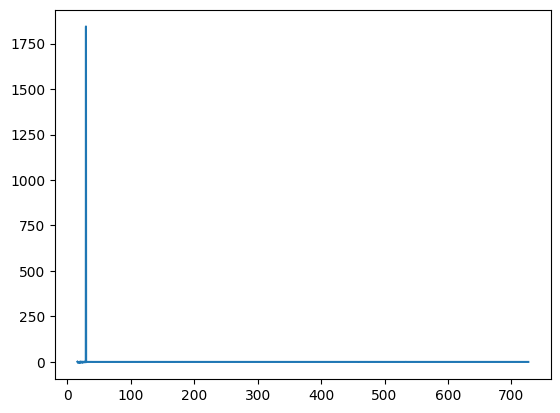

plotting motor_engine_ratio


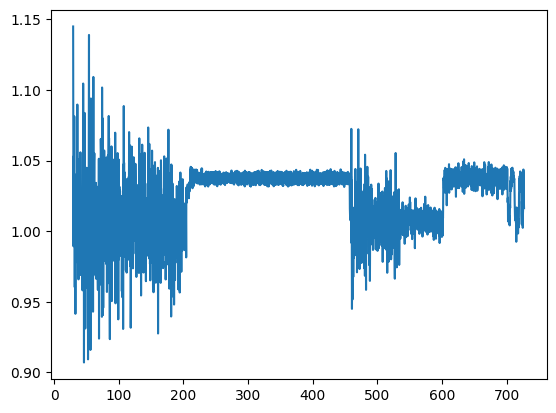

plotting motor_throttle_ratio


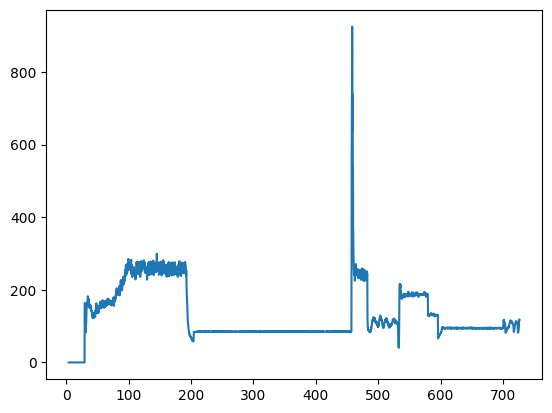

plotting motor_power_ratio


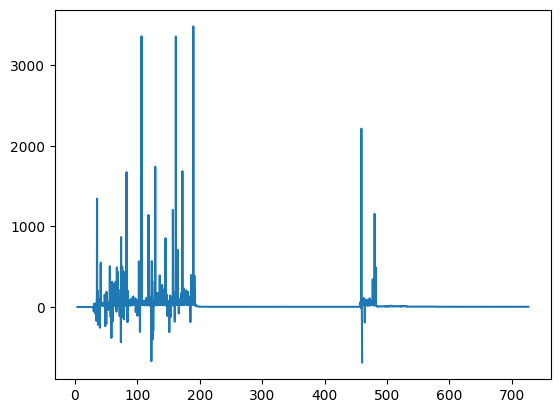

In [75]:
df_arr = validate_motor_speed(df_clean)
plot(df_arr)

In [80]:
validate_intake_temperature(df_clean)
validate_engine_coolant_temperature(df_clean)

([], [])

plotting motor_speed_change


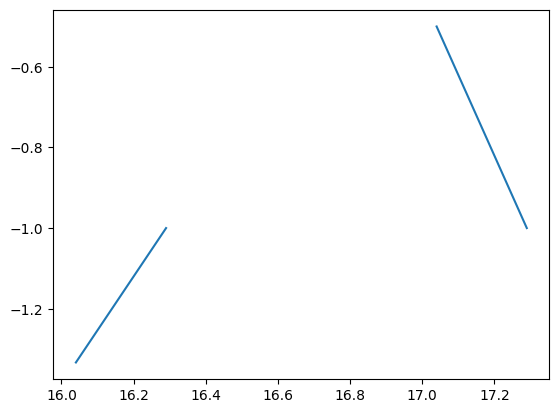

plotting motor_engine_ratio


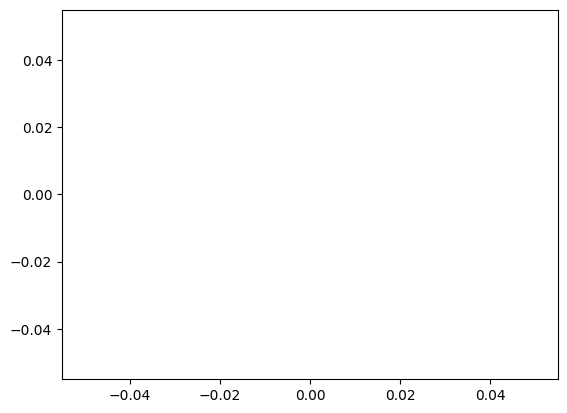

plotting motor_throttle_ratio


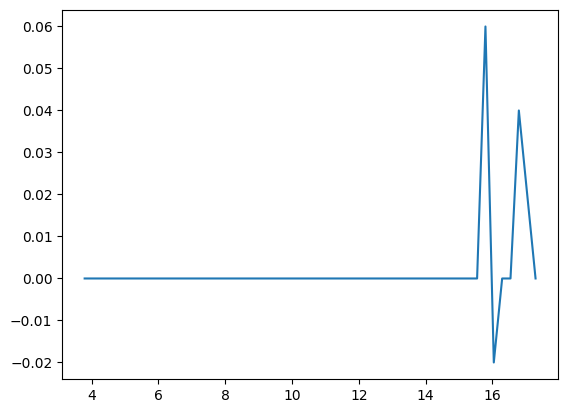

plotting motor_power_ratio


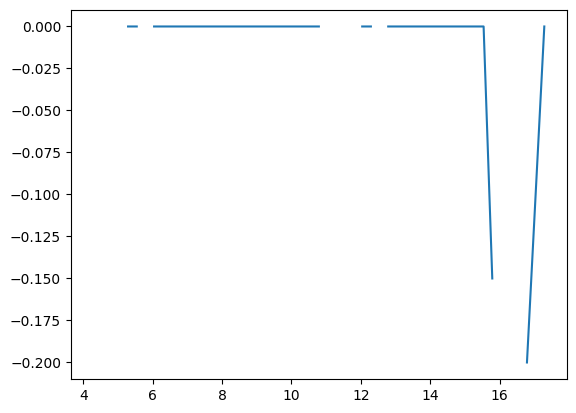

In [50]:
df_arr = validate_df(df_dirty)
plot(df_arr)